# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [2]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2022-08-08 08:11:56--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2022-08-08 08:11:56 (89.3 MB/s) - ‘tiny_img.py’ saved [813/813]

--2022-08-08 08:11:56--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

In [1]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was already downloaded to './tiny-imagenet-200.zip'. Skip downloading
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [2]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

torch.manual_seed(0)
torch.backends.cudnn.benchmark = True


def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:1'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [4]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(
         brightness=0.5,
         hue=0.3
     ),
     #transforms.RandomEqualize(p=0.3),
     # you may add any other transforms here
     transforms.RandomVerticalFlip(0.3),
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [5]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)
#train_dataset = torchvision.datasets.ImageFolder(root='tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [00:49<00:00,  4.01it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [6]:
from torch.utils.data import Dataset
from tiny_img_dataset import read_rgb_image
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([item[1] for item in annotations])))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = read_rgb_image(img_name)
            #self.images.append(image)
            
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [7]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:05<00:00, 1988.09it/s]


For the most cases the default `DataLoader` will be good enough.

In [8]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

In [9]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [10]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [11]:
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [12]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.relu(self.bn(self.conv(x)))
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(
                f'conv_block_{block_index + 1}_layer_{layer_index_in_block + 1}',
                ConvBNRelu(in_channels, out_channels, kernel_size=3)
            )
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [13]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [14]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [15]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [16]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [17]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [00:17<00:00, 90.83it/s] 


Epoch 1 of 30 took 19.084s
  training loss (in-iteration): 	4.561122
  validation accuracy: 			9.11 %


100%|██████████| 1563/1563 [00:17<00:00, 89.27it/s] 


Epoch 2 of 30 took 19.432s
  training loss (in-iteration): 	3.925186
  validation accuracy: 			17.49 %


100%|██████████| 1563/1563 [00:17<00:00, 89.26it/s] 


Epoch 3 of 30 took 19.391s
  training loss (in-iteration): 	3.633357
  validation accuracy: 			19.36 %


100%|██████████| 1563/1563 [00:17<00:00, 88.45it/s] 


Epoch 4 of 30 took 19.606s
  training loss (in-iteration): 	3.449827
  validation accuracy: 			20.68 %


100%|██████████| 1563/1563 [00:17<00:00, 89.78it/s] 


Epoch 5 of 30 took 19.451s
  training loss (in-iteration): 	3.311973
  validation accuracy: 			25.98 %


100%|██████████| 1563/1563 [00:17<00:00, 90.62it/s] 


Epoch 6 of 30 took 19.161s
  training loss (in-iteration): 	3.209022
  validation accuracy: 			27.38 %


100%|██████████| 1563/1563 [00:17<00:00, 90.30it/s] 


Epoch 7 of 30 took 19.209s
  training loss (in-iteration): 	3.121241
  validation accuracy: 			28.85 %


100%|██████████| 1563/1563 [00:17<00:00, 89.42it/s] 


Epoch 8 of 30 took 19.437s
  training loss (in-iteration): 	3.049639
  validation accuracy: 			29.46 %


100%|██████████| 1563/1563 [00:17<00:00, 89.34it/s] 


Epoch 9 of 30 took 19.624s
  training loss (in-iteration): 	2.988149
  validation accuracy: 			30.60 %


100%|██████████| 1563/1563 [00:17<00:00, 89.80it/s] 


Epoch 10 of 30 took 19.534s
  training loss (in-iteration): 	2.935001
  validation accuracy: 			32.07 %


100%|██████████| 1563/1563 [00:17<00:00, 90.34it/s] 


Epoch 11 of 30 took 19.402s
  training loss (in-iteration): 	2.885759
  validation accuracy: 			32.52 %


100%|██████████| 1563/1563 [00:17<00:00, 90.92it/s] 


Epoch 12 of 30 took 19.207s
  training loss (in-iteration): 	2.844348
  validation accuracy: 			33.37 %


100%|██████████| 1563/1563 [00:17<00:00, 88.96it/s] 


Epoch 13 of 30 took 19.686s
  training loss (in-iteration): 	2.802055
  validation accuracy: 			33.27 %


100%|██████████| 1563/1563 [00:17<00:00, 90.17it/s] 


Epoch 14 of 30 took 19.444s
  training loss (in-iteration): 	2.768647
  validation accuracy: 			34.17 %


100%|██████████| 1563/1563 [00:17<00:00, 88.85it/s] 


Epoch 15 of 30 took 19.496s
  training loss (in-iteration): 	2.739294
  validation accuracy: 			33.16 %


100%|██████████| 1563/1563 [00:17<00:00, 88.07it/s] 


Epoch 16 of 30 took 19.904s
  training loss (in-iteration): 	2.709012
  validation accuracy: 			35.42 %


100%|██████████| 1563/1563 [00:17<00:00, 88.14it/s] 


Epoch 17 of 30 took 19.885s
  training loss (in-iteration): 	2.678213
  validation accuracy: 			33.91 %


100%|██████████| 1563/1563 [00:17<00:00, 88.31it/s] 


Epoch 18 of 30 took 19.804s
  training loss (in-iteration): 	2.652125
  validation accuracy: 			35.70 %


100%|██████████| 1563/1563 [00:17<00:00, 90.13it/s] 


Epoch 19 of 30 took 19.489s
  training loss (in-iteration): 	2.625736
  validation accuracy: 			35.94 %


100%|██████████| 1563/1563 [00:17<00:00, 88.94it/s] 


Epoch 20 of 30 took 19.664s
  training loss (in-iteration): 	2.605218
  validation accuracy: 			34.91 %


100%|██████████| 1563/1563 [00:17<00:00, 89.39it/s] 


Epoch 21 of 30 took 19.631s
  training loss (in-iteration): 	2.584034
  validation accuracy: 			37.25 %


100%|██████████| 1563/1563 [00:17<00:00, 89.78it/s] 


Epoch 22 of 30 took 19.569s
  training loss (in-iteration): 	2.562987
  validation accuracy: 			35.43 %


100%|██████████| 1563/1563 [00:17<00:00, 88.32it/s] 


Epoch 23 of 30 took 19.860s
  training loss (in-iteration): 	2.543561
  validation accuracy: 			37.80 %


100%|██████████| 1563/1563 [00:17<00:00, 89.09it/s] 


Epoch 24 of 30 took 19.682s
  training loss (in-iteration): 	2.528658
  validation accuracy: 			37.20 %


100%|██████████| 1563/1563 [00:17<00:00, 89.12it/s] 


Epoch 25 of 30 took 19.587s
  training loss (in-iteration): 	2.507905
  validation accuracy: 			38.34 %


100%|██████████| 1563/1563 [00:17<00:00, 89.98it/s] 


Epoch 26 of 30 took 19.500s
  training loss (in-iteration): 	2.494328
  validation accuracy: 			37.39 %


100%|██████████| 1563/1563 [00:17<00:00, 88.22it/s] 


Epoch 27 of 30 took 19.867s
  training loss (in-iteration): 	2.473331
  validation accuracy: 			36.90 %


100%|██████████| 1563/1563 [00:17<00:00, 87.97it/s] 


Epoch 28 of 30 took 19.900s
  training loss (in-iteration): 	2.466460
  validation accuracy: 			38.21 %


100%|██████████| 1563/1563 [00:17<00:00, 89.07it/s] 


Epoch 29 of 30 took 19.696s
  training loss (in-iteration): 	2.447842
  validation accuracy: 			38.52 %


100%|██████████| 1563/1563 [00:17<00:00, 89.52it/s] 


Epoch 30 of 30 took 19.598s
  training loss (in-iteration): 	2.432772
  validation accuracy: 			37.85 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [76]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        residual = self.relu1(self.bn1(self.conv1(x)))
        residual = self.relu2(self.bn2(self.conv2(residual)))
        
        if self.conv3 is not None:
            x = self.conv3(x)
        
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(
                f'conv_block_{i + 1}_layer_{j +1}',
                ResNetBlock2(in_channels, out_channels, stride=stride)
                            )
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [82]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [00:23<00:00, 65.29it/s]


Epoch 1 of 30 took 26.154s
  training loss (in-iteration): 	4.849396
  validation accuracy: 			8.07 %


100%|██████████| 1563/1563 [00:22<00:00, 68.25it/s]


Epoch 2 of 30 took 25.310s
  training loss (in-iteration): 	4.173304
  validation accuracy: 			13.90 %


100%|██████████| 1563/1563 [00:24<00:00, 64.52it/s]


Epoch 3 of 30 took 26.663s
  training loss (in-iteration): 	3.784961
  validation accuracy: 			19.38 %


100%|██████████| 1563/1563 [00:23<00:00, 67.15it/s]


Epoch 4 of 30 took 25.634s
  training loss (in-iteration): 	3.547667
  validation accuracy: 			21.81 %


100%|██████████| 1563/1563 [00:22<00:00, 68.13it/s]


Epoch 5 of 30 took 25.366s
  training loss (in-iteration): 	3.366337
  validation accuracy: 			25.98 %


100%|██████████| 1563/1563 [00:23<00:00, 66.21it/s]


Epoch 6 of 30 took 27.418s
  training loss (in-iteration): 	3.226029
  validation accuracy: 			25.78 %


100%|██████████| 1563/1563 [00:23<00:00, 67.14it/s]


Epoch 7 of 30 took 26.342s
  training loss (in-iteration): 	3.109528
  validation accuracy: 			29.73 %


100%|██████████| 1563/1563 [00:22<00:00, 68.54it/s]


Epoch 8 of 30 took 25.614s
  training loss (in-iteration): 	3.010999
  validation accuracy: 			31.13 %


100%|██████████| 1563/1563 [00:23<00:00, 66.23it/s]


Epoch 9 of 30 took 25.734s
  training loss (in-iteration): 	2.927957
  validation accuracy: 			30.81 %


100%|██████████| 1563/1563 [00:23<00:00, 66.81it/s]


Epoch 10 of 30 took 25.537s
  training loss (in-iteration): 	2.854873
  validation accuracy: 			33.36 %


100%|██████████| 1563/1563 [00:23<00:00, 65.99it/s]


Epoch 11 of 30 took 26.022s
  training loss (in-iteration): 	2.791545
  validation accuracy: 			33.52 %


100%|██████████| 1563/1563 [00:22<00:00, 68.21it/s]


Epoch 12 of 30 took 25.303s
  training loss (in-iteration): 	2.727961
  validation accuracy: 			35.62 %


100%|██████████| 1563/1563 [00:22<00:00, 68.86it/s]


Epoch 13 of 30 took 25.064s
  training loss (in-iteration): 	2.676152
  validation accuracy: 			36.50 %


100%|██████████| 1563/1563 [00:22<00:00, 69.34it/s]


Epoch 14 of 30 took 24.939s
  training loss (in-iteration): 	2.630538
  validation accuracy: 			37.34 %


100%|██████████| 1563/1563 [00:23<00:00, 67.06it/s]


Epoch 15 of 30 took 25.628s
  training loss (in-iteration): 	2.584734
  validation accuracy: 			37.83 %


100%|██████████| 1563/1563 [00:22<00:00, 69.20it/s]


Epoch 16 of 30 took 24.949s
  training loss (in-iteration): 	2.540360
  validation accuracy: 			38.40 %


100%|██████████| 1563/1563 [00:23<00:00, 67.93it/s]


Epoch 17 of 30 took 25.370s
  training loss (in-iteration): 	2.508084
  validation accuracy: 			39.15 %


100%|██████████| 1563/1563 [00:22<00:00, 68.89it/s]


Epoch 18 of 30 took 25.074s
  training loss (in-iteration): 	2.467928
  validation accuracy: 			38.73 %


100%|██████████| 1563/1563 [00:23<00:00, 66.98it/s]


Epoch 19 of 30 took 25.691s
  training loss (in-iteration): 	2.440140
  validation accuracy: 			39.37 %


100%|██████████| 1563/1563 [00:22<00:00, 68.93it/s]


Epoch 20 of 30 took 25.058s
  training loss (in-iteration): 	2.410618
  validation accuracy: 			40.04 %


100%|██████████| 1563/1563 [00:22<00:00, 68.19it/s]


Epoch 21 of 30 took 25.264s
  training loss (in-iteration): 	2.380804
  validation accuracy: 			40.43 %


100%|██████████| 1563/1563 [00:22<00:00, 68.27it/s]


Epoch 22 of 30 took 25.249s
  training loss (in-iteration): 	2.355147
  validation accuracy: 			40.33 %


100%|██████████| 1563/1563 [00:22<00:00, 68.88it/s]


Epoch 23 of 30 took 25.067s
  training loss (in-iteration): 	2.328205
  validation accuracy: 			40.55 %


100%|██████████| 1563/1563 [00:22<00:00, 68.81it/s]


Epoch 24 of 30 took 24.971s
  training loss (in-iteration): 	2.304602
  validation accuracy: 			40.85 %


100%|██████████| 1563/1563 [00:23<00:00, 66.57it/s]


Epoch 25 of 30 took 25.775s
  training loss (in-iteration): 	2.283764
  validation accuracy: 			39.38 %


100%|██████████| 1563/1563 [00:22<00:00, 68.57it/s]


Epoch 26 of 30 took 25.169s
  training loss (in-iteration): 	2.260412
  validation accuracy: 			41.40 %


100%|██████████| 1563/1563 [00:22<00:00, 68.37it/s]


Epoch 27 of 30 took 25.271s
  training loss (in-iteration): 	2.235437
  validation accuracy: 			41.68 %


100%|██████████| 1563/1563 [00:22<00:00, 69.11it/s]


Epoch 28 of 30 took 24.999s
  training loss (in-iteration): 	2.213178
  validation accuracy: 			41.49 %


100%|██████████| 1563/1563 [00:22<00:00, 69.16it/s]


Epoch 29 of 30 took 25.040s
  training loss (in-iteration): 	2.193005
  validation accuracy: 			42.42 %


100%|██████████| 1563/1563 [00:22<00:00, 68.58it/s]


Epoch 30 of 30 took 25.176s
  training loss (in-iteration): 	2.179752
  validation accuracy: 			41.87 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [83]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [00:22<00:00, 69.98it/s]


Epoch 1 of 30 took 24.676s
  training loss (in-iteration): 	4.842382
  validation accuracy: 			6.07 %


100%|██████████| 1563/1563 [00:22<00:00, 69.02it/s]


Epoch 2 of 30 took 24.977s
  training loss (in-iteration): 	4.297097
  validation accuracy: 			9.18 %


100%|██████████| 1563/1563 [00:22<00:00, 70.57it/s]


Epoch 3 of 30 took 24.489s
  training loss (in-iteration): 	4.019602
  validation accuracy: 			11.71 %


100%|██████████| 1563/1563 [00:21<00:00, 71.17it/s]


Epoch 4 of 30 took 24.318s
  training loss (in-iteration): 	3.827042
  validation accuracy: 			13.54 %


100%|██████████| 1563/1563 [00:22<00:00, 70.77it/s]


Epoch 5 of 30 took 24.467s
  training loss (in-iteration): 	3.681148
  validation accuracy: 			16.88 %


100%|██████████| 1563/1563 [00:22<00:00, 70.90it/s]


Epoch 6 of 30 took 24.426s
  training loss (in-iteration): 	3.563383
  validation accuracy: 			19.79 %


100%|██████████| 1563/1563 [00:21<00:00, 71.44it/s]


Epoch 7 of 30 took 24.236s
  training loss (in-iteration): 	3.461132
  validation accuracy: 			21.76 %


100%|██████████| 1563/1563 [00:22<00:00, 69.70it/s]


Epoch 8 of 30 took 24.757s
  training loss (in-iteration): 	3.365899
  validation accuracy: 			24.26 %


100%|██████████| 1563/1563 [00:22<00:00, 70.13it/s]


Epoch 9 of 30 took 24.617s
  training loss (in-iteration): 	3.278763
  validation accuracy: 			25.95 %


100%|██████████| 1563/1563 [00:22<00:00, 68.84it/s]


Epoch 10 of 30 took 25.087s
  training loss (in-iteration): 	3.194522
  validation accuracy: 			26.14 %


100%|██████████| 1563/1563 [00:22<00:00, 69.27it/s]


Epoch 11 of 30 took 24.988s
  training loss (in-iteration): 	3.124234
  validation accuracy: 			27.24 %


100%|██████████| 1563/1563 [00:22<00:00, 69.12it/s]


Epoch 12 of 30 took 24.953s
  training loss (in-iteration): 	3.059142
  validation accuracy: 			27.92 %


100%|██████████| 1563/1563 [00:22<00:00, 69.56it/s]


Epoch 13 of 30 took 24.826s
  training loss (in-iteration): 	2.995898
  validation accuracy: 			28.30 %


100%|██████████| 1563/1563 [00:22<00:00, 68.52it/s]


Epoch 14 of 30 took 25.164s
  training loss (in-iteration): 	2.944191
  validation accuracy: 			31.02 %


100%|██████████| 1563/1563 [00:21<00:00, 71.11it/s]


Epoch 15 of 30 took 24.299s
  training loss (in-iteration): 	2.895097
  validation accuracy: 			31.46 %


100%|██████████| 1563/1563 [00:22<00:00, 68.50it/s]


Epoch 16 of 30 took 25.203s
  training loss (in-iteration): 	2.842996
  validation accuracy: 			31.98 %


100%|██████████| 1563/1563 [00:22<00:00, 70.13it/s]


Epoch 17 of 30 took 24.657s
  training loss (in-iteration): 	2.797304
  validation accuracy: 			31.96 %


100%|██████████| 1563/1563 [00:23<00:00, 67.35it/s]


Epoch 18 of 30 took 25.606s
  training loss (in-iteration): 	2.761696
  validation accuracy: 			33.18 %


100%|██████████| 1563/1563 [00:22<00:00, 68.55it/s]


Epoch 19 of 30 took 25.029s
  training loss (in-iteration): 	2.722199
  validation accuracy: 			34.86 %


100%|██████████| 1563/1563 [00:22<00:00, 68.78it/s]


Epoch 20 of 30 took 25.124s
  training loss (in-iteration): 	2.682325
  validation accuracy: 			32.86 %


100%|██████████| 1563/1563 [00:22<00:00, 70.65it/s]


Epoch 21 of 30 took 24.488s
  training loss (in-iteration): 	2.647767
  validation accuracy: 			34.36 %


100%|██████████| 1563/1563 [00:22<00:00, 70.42it/s]


Epoch 22 of 30 took 24.531s
  training loss (in-iteration): 	2.614888
  validation accuracy: 			35.76 %


100%|██████████| 1563/1563 [00:21<00:00, 71.61it/s]


Epoch 23 of 30 took 24.137s
  training loss (in-iteration): 	2.579026
  validation accuracy: 			35.78 %


100%|██████████| 1563/1563 [00:22<00:00, 68.62it/s]


Epoch 24 of 30 took 25.022s
  training loss (in-iteration): 	2.551610
  validation accuracy: 			36.97 %


100%|██████████| 1563/1563 [00:22<00:00, 69.82it/s]


Epoch 25 of 30 took 24.775s
  training loss (in-iteration): 	2.526469
  validation accuracy: 			37.50 %


100%|██████████| 1563/1563 [00:22<00:00, 70.26it/s]


Epoch 26 of 30 took 24.604s
  training loss (in-iteration): 	2.495975
  validation accuracy: 			35.98 %


100%|██████████| 1563/1563 [00:22<00:00, 70.35it/s]


Epoch 27 of 30 took 24.621s
  training loss (in-iteration): 	2.469046
  validation accuracy: 			37.73 %


100%|██████████| 1563/1563 [00:23<00:00, 67.00it/s]


Epoch 28 of 30 took 25.734s
  training loss (in-iteration): 	2.449672
  validation accuracy: 			37.31 %


100%|██████████| 1563/1563 [00:22<00:00, 69.90it/s]


Epoch 29 of 30 took 24.724s
  training loss (in-iteration): 	2.423039
  validation accuracy: 			38.53 %


100%|██████████| 1563/1563 [00:22<00:00, 70.00it/s]


Epoch 30 of 30 took 24.702s
  training loss (in-iteration): 	2.396147
  validation accuracy: 			36.86 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [ ]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

In [117]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                X_batch_transformed = transformations(X_batch)
                logits = model(X_batch_transformed)
                
                logits_per_transform.append(logits)
                
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            stack_logits = torch.zeros((n_transformations, X_batch.shape[0], 200)).to(device)
            for i in range(n_transformations):
                stack_logits[i] = logits_per_transform[i]
                
            averaged_logits = stack_logits.mean(dim=0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.detach().cpu() == y_pred.detach().cpu()).numpy()))
    return np.mean(accuracy)

In [119]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
    
    transforms.ColorJitter(
        brightness=0.2,
        hue=0.2
     ),
    transforms.RandomVerticalFlip(0.3),
])

In [126]:
model_accuracy = 0.4122

In [127]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:04<00:00, 33.17it/s]


Model accuracy with 3 forward runs is 0.41709792993630573


100%|██████████| 157/157 [00:06<00:00, 24.51it/s]


Model accuracy with 5 forward runs is 0.42018312101910826


100%|██████████| 157/157 [00:08<00:00, 19.38it/s]


Model accuracy with 7 forward runs is 0.42237261146496813


100%|██████████| 157/157 [00:09<00:00, 15.94it/s]


Model accuracy with 9 forward runs is 0.4250597133757962


100%|██████████| 157/157 [00:13<00:00, 11.86it/s]


Model accuracy with 13 forward runs is 0.4271496815286624


100%|██████████| 157/157 [00:14<00:00, 10.54it/s]

Model accuracy with 15 forward runs is 0.42854299363057324


Let's visualize what we have computed

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

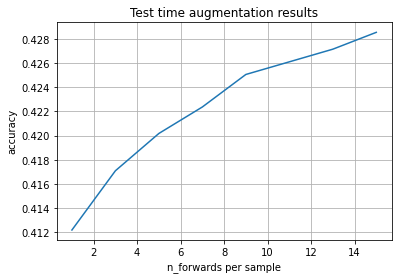

In [129]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape